In [1]:
#import packages
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr
import functools as ft
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry
import xskillscore as xs
from sklearn.linear_model import LinearRegression


In [2]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [3]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],# reduce along 'model'
                        )
    return slope

In [4]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [5]:
def get_model_DS(MODS, v1, v2, lat, lat_r, lon, lon_r):
    for i, model in enumerate(MODS.keys()):
        HB = MODS[model]
        v1a = HB[v1]
        v2a = HB[v2]
        if len(v1a.coords) > 3:
            #print(v1a.coords)
            v1a = v1a.drop_vars('lev')
        if len(v2a.coords) >3:
            v2a = v2a.drop_vars('lev')
        if v2 == 'wcur':
            v2a = v2a.groupby('time.month').mean('time')
        v1a = get_region(v1a, lat, lat_r, lon, lon_r)
        v2a = get_region(v2a, lat, lat_r, lon, lon_r)


        v1a = v1a.assign_coords({"model":model})
        v2a = v2a.assign_coords({"model":model})
        if i == 0:
            v1m = v1a
            v2m = v2a
        else:
            v1m = xr.concat([v1m, v1a], dim = 'model')
            #print(v2a, model)
            v2m = xr.concat([v2m, v2a], dim = 'model')
    DS = xr.Dataset(data_vars=dict(
            v1m=(["model", "month"], v1m),
            v2m=(["model", "month"], v2m)),
        coords=dict(
            month=(v1m.month),
            model=(v1m.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    DS = DS.rename({'v1m':v1, 'v2m':v2})
    return DS

In [6]:
#load in data
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'lw':'_netLW.nc', 'sw':'_netSW.nc', 'lhf':'_hfls.nc', 
             'shf':'_hfss.nc', 'SST': '_tos.nc', 'dtdx':'_dtx.nc', 'dtdy':'_dty.nc', 'dtdz':'_dtz.nc',
             'wcur':'_wcur.nc', 'vcur':'_vcur.nc', 'ucur':'_ucur.nc', 
             'uw':'_tauu.nc', 'vw':'_tauv.nc','wspd':'_wspd.nc', 'wsc':'_wsc.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netLW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netSW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfls.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfss.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_f

In [7]:
#load in REAn products with all HB terms
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/REAN_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'Q':'_qnet.nc', 'lw':'_lwrf.nc', 'sw':'_swrf.nc', 'lhf':'_lhf.nc', 
             'shf':'_shf.nc', 'SST': '_tos.nc', 'dtdx':'_dtx.nc', 'dtdy':'_dty.nc', 'dtdz':'_dtz.nc',
             'wcur':'_wcur.nc', 'vcur':'_vcur.nc', 'ucur':'_ucur.nc', 
             'uw':'_tauu.nc', 'vw':'_tauv.nc','wspd':'_wspd.nc','wsc':'_wsc.nc'}
OBS={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    mod={}
    for key in varis.keys():
        #input file
        inp_files = (os.path.join(datadir, model, str(model+varis[key])))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #put into dict
            mod[key]=var
            OBS[model] = mod

        except Exception as e:
            print(e)
            mod[key]=0
            OBS[model] = mod
            pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_lwrf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_swrf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_lhf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_shf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN

In [8]:
#reverse signs on advection, pack Qnet nad HF terms separately
OBS1={}
for model in OBS.keys():
    HB = OBS[model]
    try:
        T=HB['dTdt']*(3986*1026*50)
        U=HB['ua']*(3986*1026*50)
        V=HB['va']*(3986*1026*50)
        W=HB['wa']*(3986*1026*50)
        lw=HB['lw']
        sw=HB['sw']
        lhf=HB['lhf']
        shf=HB['shf']
        if model == 'ERA5':
            Q=(lw+sw+lhf+shf)#terms are all positive so have to add in sign, and scale to degC/month
        elif model == 'OAFLUX':
            Q = HB['Q']
        else:
            Q = HB['Q']*(3986*1026*50)
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict with correct sign so everything is additive
        HB.update({'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'Q':Q, 'res':resid, 'SST':SST, 
             'lw':lw, 'sw':sw, 'lhf':lhf, 'shf':shf,})
        #update models dictionary
        OBS.update({model:HB})
    except Exception as e:
        print(e, model)


In [9]:
#reverse signs on advection, pack Qnet nad HF terms separately
models1={}
model_HF={}
for model in models.keys():
    try:
        HB=models[model]
        T=HB['dTdt']*(3986*1026*50)
        U=HB['ua']*(3986*1026*50)
        V=HB['va']*(3986*1026*50)
        W=HB['wa']*(3986*1026*50)
        lw=HB['lw']
        sw=HB['sw']
        lhf=HB['lhf']
        shf=HB['shf']
        Q=(lw+sw-lhf-shf)#terms are all positive so have to add in sign, and scale to degC/month
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict with correct sign so everything is additive
        HB.update({'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'Q':Q, 'res':resid, 'SST':SST, 
             'lw':lw, 'sw':sw, 'lhf':-lhf, 'shf':-shf,})
        #update models dictionary
        models.update({model:HB})
    except Exception as e:
        print(e, model)


In [10]:
#define markers for scatter plots
marks = ['o', '+', 'x', '*', '.']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
test ={}
count = 0
for col in colors:
    for mark in marks:
        test[count] = [mark, col]
        count = count+1

In [11]:
sortedkeys=sorted(models.keys(), key=lambda x:x.lower())
LGND={}
for i, name in enumerate(sortedkeys):
    LGND[name] = test[i]

In [12]:
colorso = ['c', 'y', 'm', 'b', 'r', 'gray']

In [13]:
LGNDO={}
for i, name in enumerate(OBS.keys()):
    LGNDO[name] = colorso[i]

In [14]:
def get_model_DS(MODS, v1, v2, lat, lat_r, lon, lon_r):
    sortedkeys=sorted(MODS.keys(), key=lambda x:x.lower())
    for i, model in enumerate(sortedkeys):
        HB = MODS[model]
        v1a = HB[v1]
        v2a = HB[v2]
        if len(v1a.coords) > 3:
            #print(v1a.coords)
            v1a = v1a.drop_vars('lev')
        if len(v2a.coords) >3:
            v2a = v2a.drop_vars('lev')
        if v2 == 'wcur':
            v2a = v2a.groupby('time.month').mean('time')
        v1a = get_region(v1a, lat, lat_r, lon, lon_r)
        v2a = get_region(v2a, lat, lat_r, lon, lon_r)


        v1a = v1a.assign_coords({"model":model})
        v2a = v2a.assign_coords({"model":model})
        if i == 0:
            v1m = v1a
            v2m = v2a
        else:
            v1m = xr.concat([v1m, v1a], dim = 'model')
            #print(v2a, model)
            v2m = xr.concat([v2m, v2a], dim = 'model')
    DS = xr.Dataset(data_vars=dict(
            v1m=(["model", "month"], v1m),
            v2m=(["model", "month"], v2m)),
        coords=dict(
            month=(v1m.month),
            model=(v1m.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    DS = DS.rename({'v1m':v1, 'v2m':v2})
    return DS

In [20]:
def plot_scatter_c_r(MODS,obs, d, v1, v2, lat, lat1, lon, lon1, month):
    title_dict = {1:'a',2:'b', 3:'c', 4:'d',5:'e'}
    
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    DS = DS.sel(month=month).mean('month')
    DSM = DS.median('model')
    for i, name in enumerate(DS.model.values):
        axs[d].scatter(DS[list(DS.keys())[0]][i],DS[list(DS.keys())[1]][i], c=test[i][1], marker=test[i][0], s = 53, label = name)
    axs[d].scatter(DSM[list(DS.keys())[0]], DSM[list(DS.keys())[1]], marker = 's', edgecolors = 'k', c = 'white', s = 53,label = 'MMM')
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    axs[d].plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    axs[d].set_title(title_dict[d+1]+')\n slope = '+
              f'{regr.coef_[0][0]:.2f}'+
              '\n Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}', loc='left')
    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
            Ox = Ox.sel(month=month).mean('month')
            Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
            Oy = Oy.sel(month=month).mean('month')
            axs[d].scatter(Ox, Oy, marker = 's', facecolors=colorso[i], s = 53,label = prod)
        except Exception as e:
            pass
        try:
            if obs[prod][v1] == int(0):
                Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
                Oy = Oy.sel(month=month).mean('month')
                axs[d].axhline(Oy, c = colorso[i], linewidth = 0.5, linestyle = '-', label = prod)
        except:
            pass
        try:
            if obs[prod][v2] == int(0):
                Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
                Ox = Ox.sel(month=month).mean('month')
                axs[d].axvline(Ox, c = colorso[i], linewidth = 0.5, linestyle = '-', label = prod)
        except:
            pass
    return

In [27]:
def plot_scatter_1panel(MODS,obs, v1, v2, lat, lat1, lon, lon1, month):#for supp figures
    plt.figure(figsize=(8,6))
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    DS = DS.sel(month=month).mean('month')
    DSM = DS.median('model')
    for i, name in enumerate(DS.model.values):
        plt.scatter(DS[list(DS.keys())[0]][i],DS[list(DS.keys())[1]][i], c=test[i][1], marker=test[i][0], label = name)
    plt.scatter(DSM[list(DS.keys())[0]], DSM[list(DS.keys())[1]], marker = 's', edgecolors = 'k', c = 'white', label = 'MMM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    plt.plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    plt.title('slope = '+
              f'{regr.coef_[0][0]:.2f}'+
              '\n Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}')

    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
            Ox = Ox.sel(month=month).mean('month')
            Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
            Oy = Oy.sel(month=month).mean('month')
            plt.scatter(Ox, Oy, marker = 's', facecolors=colorso[i], label = prod)
        except Exception as e:
            pass
        try:
            if obs[prod][v1] == int(0):
                Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
                Oy = Oy.sel(month=month).mean('month')
                plt.axhline(Oy, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
        try:
            if obs[prod][v2] == int(0):
                Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
                Ox = Ox.sel(month=month).mean('month')
                plt.axvline(Ox, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
    
    
    return DS

In [16]:
var_titles={'dTdt':'$dT/dt$ ($Wm^{-2}$)', 'ua':'U advection ($Wm^{-2}$)', 'va':'V advection ($Wm^{-2}$)',
             'wa':'W advection ($Wm^{-2}$)', 'Q':'Qnet ($Wm^{-2}$)', 'lw':'longwave radiation ($Wm^{-2}$)',
            'sw':'shortwave radiation ($Wm^{-2}$)', 'lhf':'Latent heat flux ($Wm^{-2}$)', 
             'shf':'Sensible heat flux ($Wm^{-2}$)', 'SST': 'SST degC', 
             'wcur':'Vertical flow ($ms^{-1}$)', 'vcur':'Meridional flow ($ms^{-1}$)', 'ucur':'Zonal flow ($ms^{-1}$)', 
             'uw':'Zonal wind stress ($Nm^{-2}$)', 'vw':'Meridonal wind stress ($Nm^{-2}$)','wspd':'Wind stress ($Nm^{-2}$)'}

In [17]:
#define legend stuff
handles = []
labels = []
for label, marker_color in LGND.items():
    marker, color = marker_color
    handles.append(plt.Line2D([], [], marker=marker, markersize = 10, color=color, linestyle='None'))
    labels.append(label)
for label, marker_color in LGNDO.items():
    handles.append(plt.Line2D([0], [0], marker = 's',  color=marker_color, lw=0.5))
    labels.append(label)

In [18]:
handles.append(plt.Line2D([], [], marker='s', color='white', markeredgecolor = 'k', linestyle='None'))
labels.append('MMM')

# figure 5
WTIO region correlation plots

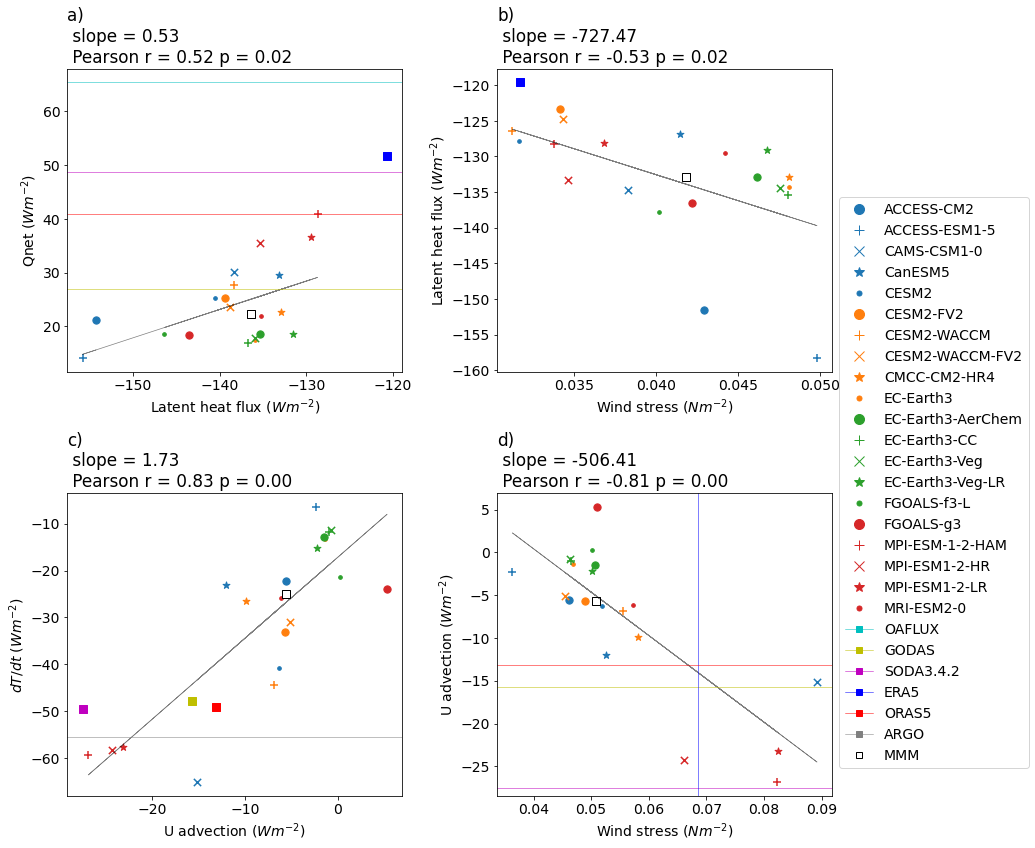

In [21]:
#figure 4
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf', 'Q','wspd', 'lhf','ua', 'dTdt','wspd', 'ua']
months = [[7,8,9,10,11,12,1,2,3,4],[12,1,2,3,4],[5,6],[5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    plot_scatter_c_r(models,OBS, i, v1, v2, -10,10,50,70, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend|
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_4.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')


# figure 7
SETIO scatter plots

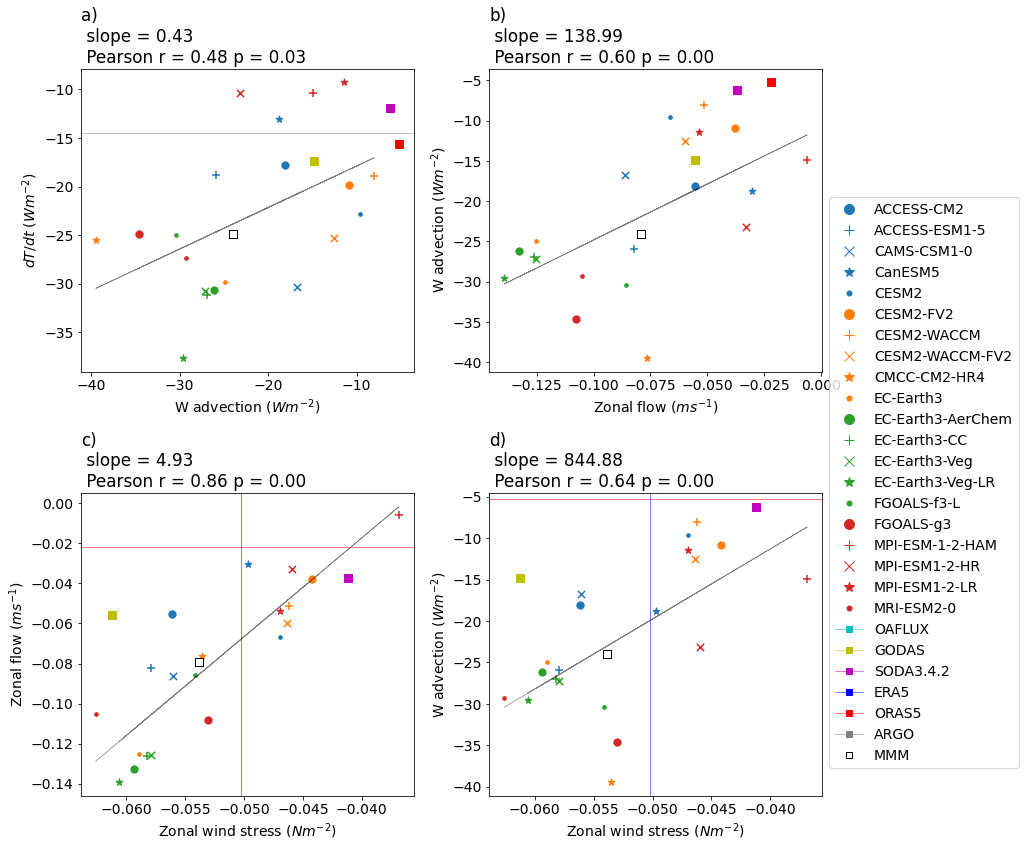

In [22]:
#figure 6
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['wa', 'dTdt','ucur', 'wa','uw', 'ucur','uw', 'wa']
months = [[7,8,9,10],[7,8,9,10],[7,8,9, 10],[7,8,9, 10]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    plot_scatter_c_r(models,OBS, i, v1, v2, -10,0,90,110, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-05-26/F_6.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_6.png', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

# Figure 8
Arabian sea Region scatter plots

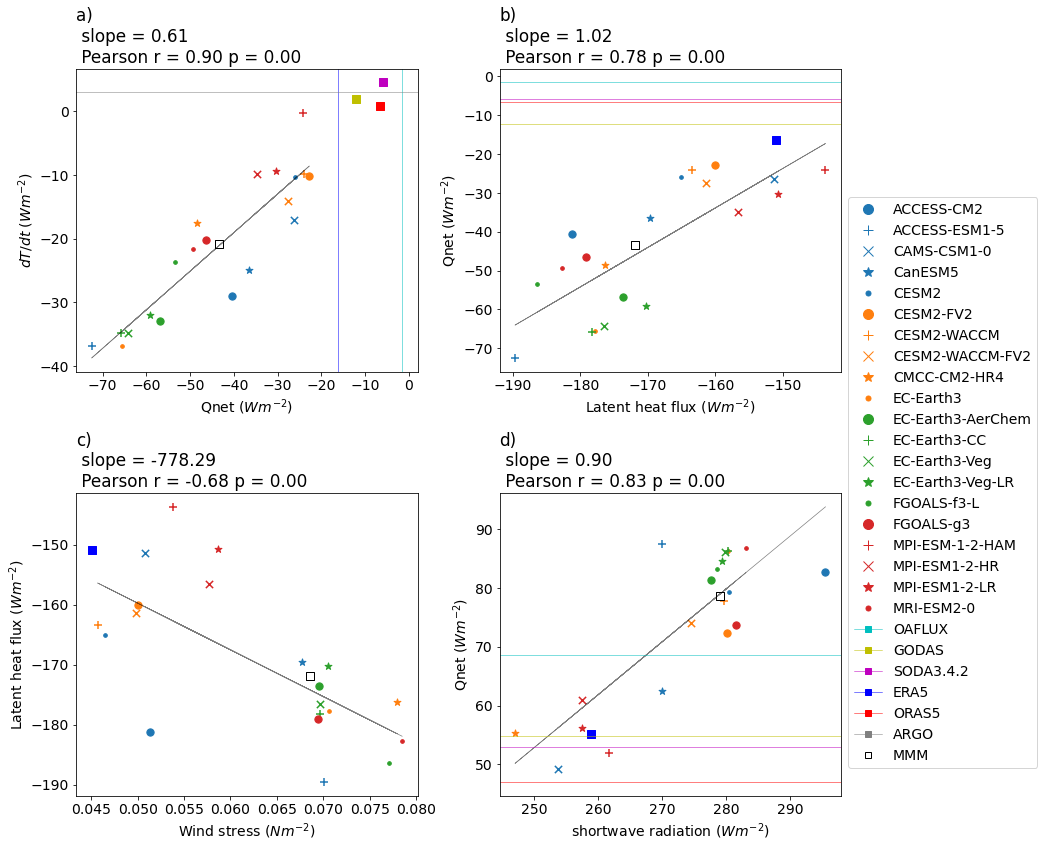

In [24]:
#figure 8
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['Q', 'dTdt','lhf', 'Q','wspd', 'lhf','sw', 'Q']
months = [[11,12,1,2,3],[11,12,1,2,3],[11,12,1,2,3],[4,5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, 10,20,50,70, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_8.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_8.png', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')
#lt.savefig('/home/z5113258/Documents/figures/Figures_jpeg300/F_8.f', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

# now create supplemenatry Figures 4-7,9

# S figure 4

In [ ]:
#WTIO SUPP FIG
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
axs = axs.ravel()
variables = ['lhf', 'Q','wspd', 'lhf','sw', 'Q', 'Q', 'dTdt','wspd', 'ucur']
months = [[5,6], [7,8,9,10,11],[10,11,12,1,2],[1,2,3],[5,6]]
for i in range(6):
    if i ==5:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        plot_scatter_c_r(models,OBS, i, v1, v2, -10,10,50,70, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
fig.delaxes(axs[5])
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N1.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

# S fig 5

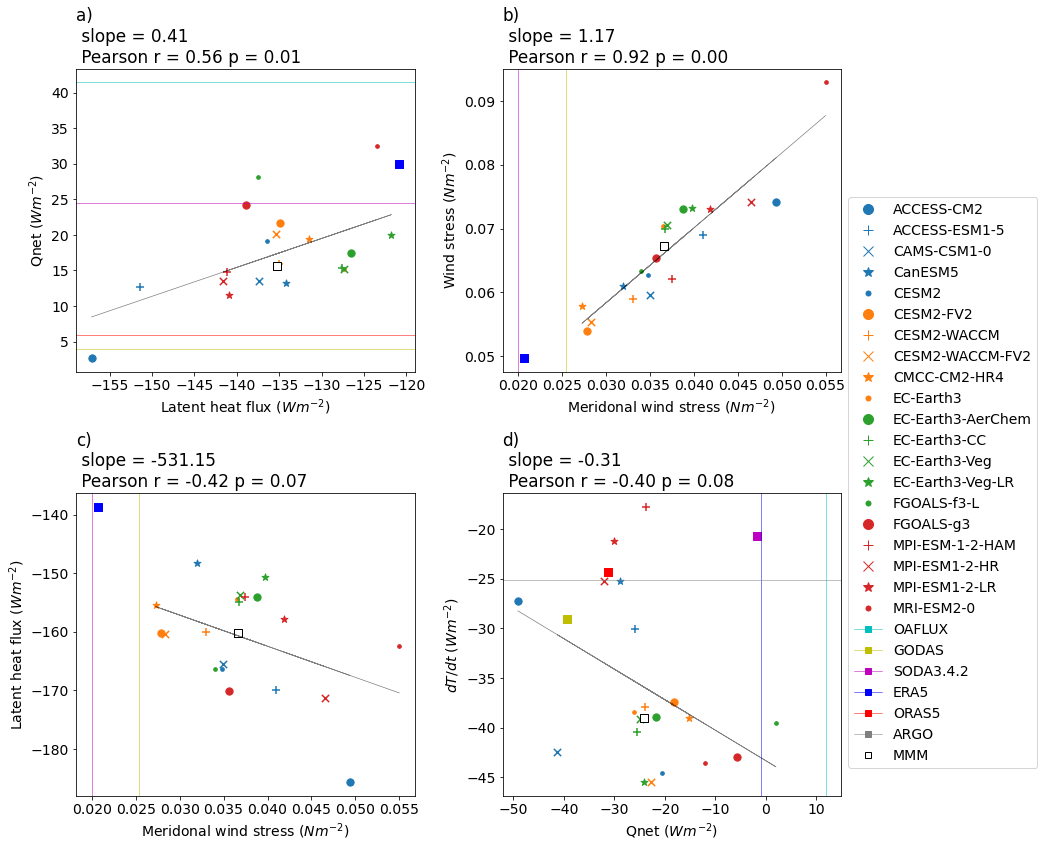

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf','Q', 'vw','wspd', 'vw', 'lhf', 'Q', 'dTdt']
months = [[1,2,3,4,5,6,7,8,9,10,11,12],[6,7],[6,7],[6,7,8,9]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,0,90,110, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')


# S fig 6

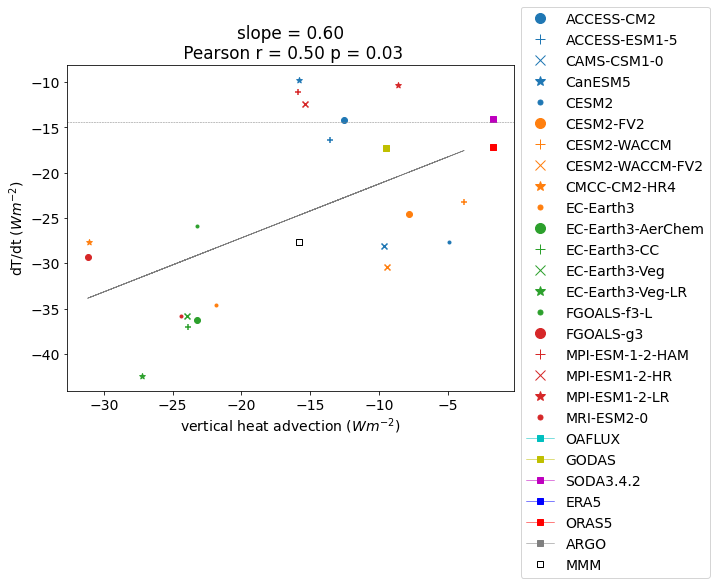

In [31]:
TA = plot_scatter_1panel(models, OBS,  'wa', 'dTdt', -10,0,90,100, [7,8,9,10])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('vertical heat advection ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')


# S fig 7

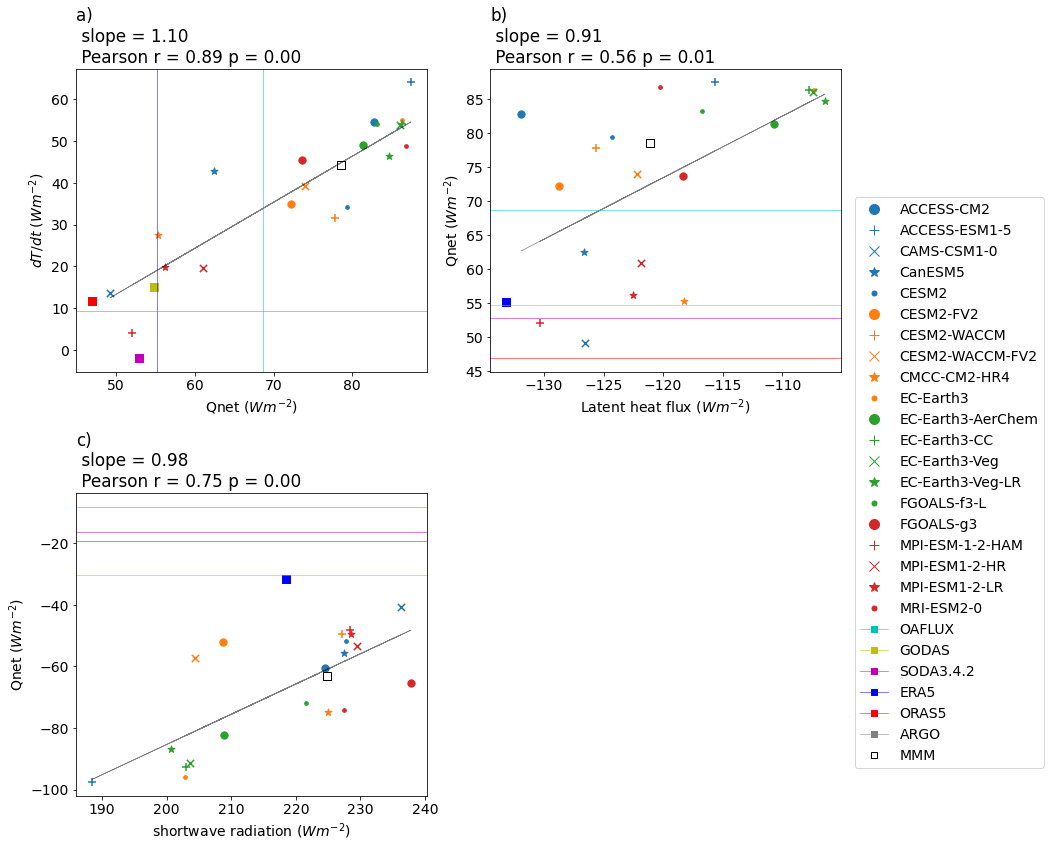

In [32]:
#Arabian Sea SUPP FIG
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['Q','dTdt', 'lhf','Q', 'sw', 'Q']
months = [[4,5,6],[4,5,6],[1,2]]
for i in range(4):
    if i>2:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, 10,20,50,70, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
fig.delaxes(axs[3])
plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')

# S fig 10

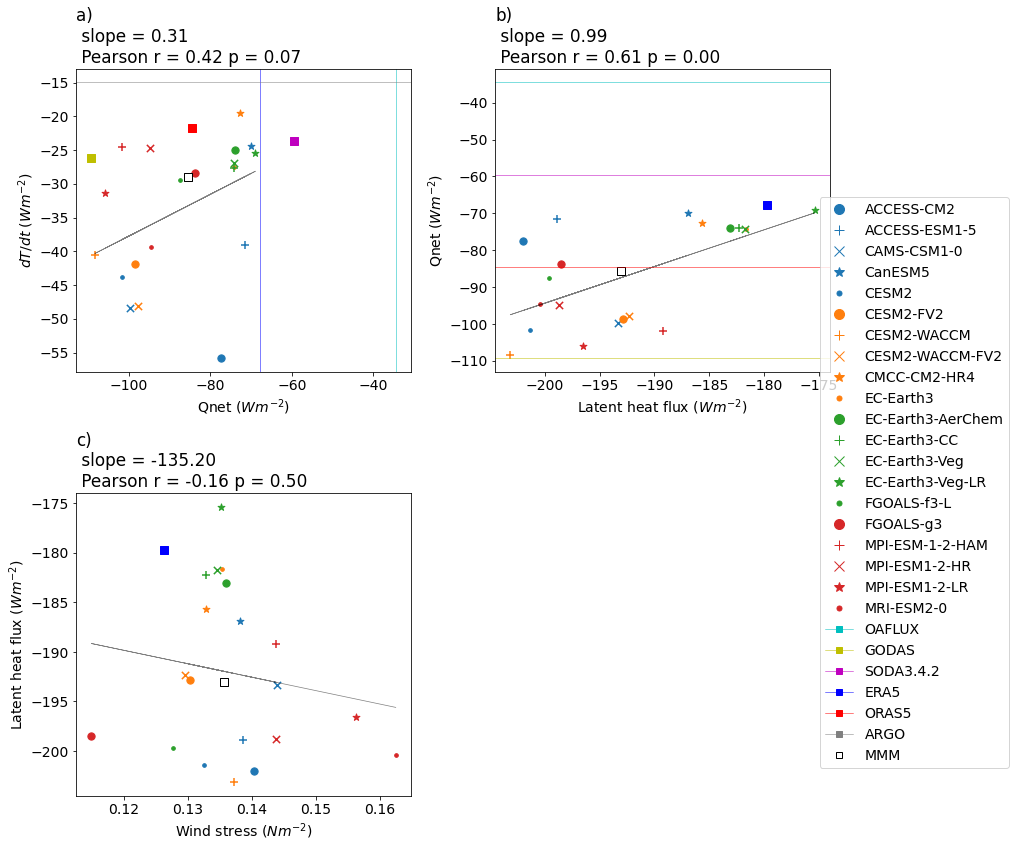

In [29]:
#Supp figure 10
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['Q', 'dTdt','lhf', 'Q','wspd', 'lhf']
months = [[5,6,7,8],[5,6,7,8],[5,6,7,8]]
for i in range(4):
    if i ==3:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, -15,-10,80,100, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend
fig.delaxes(axs[3])
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')


# S fig 12
somali coast region

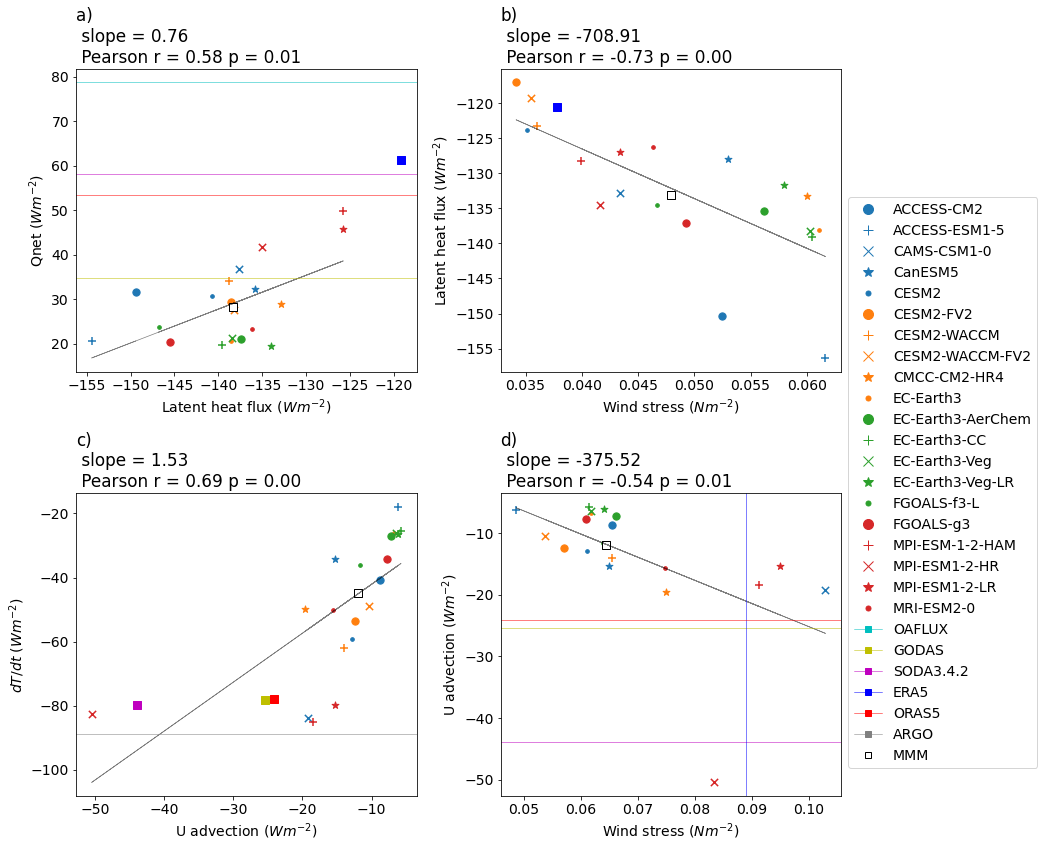

In [28]:
#figure 4 but for closer to somali coast
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf', 'Q','wspd', 'lhf','ua', 'dTdt','wspd', 'ua']
months = [[7,8,9,10,11,12,1,2,3,4],[12,1,2,3,4],[5,6],[5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,10,40,60, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend|
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_4.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_12.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')
